In [ ]:
%matplotlib inline

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 14.1MB/s 
     |████████████████████████████████| 890kB 46.7MB/s 
     |████████████████████████████████| 2.9MB 55.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4cff88e1fa4736e865d7b5c90592617d53f66bc049e86fcb40355a1c0e130a99
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

In [ ]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.6.9
pandas==1.1.5
numpy==1.18.5
torch==1.7.0+cu101
sklearn==0.22.2.post1
transformers==4.0.1
matplotlib==3.2.2


In [ ]:
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

In [ ]:
df = pd.read_csv('/content/sample_data/FinalDataSet - Sheet1 (1).csv')
df.shape

(1499, 2)

In [ ]:
df.shape

(1499, 2)

In [ ]:
df.head()

,Text,label
0,These new anti-anxiety meds make me so sleepy😴...,1
1,@xmermaidmama you can try vitamins for Olivia!...,1
2,Toby set up the humidifier for me in the room ...,1
3,I'm an 8. They also just started me on pitocin...,1
4,"@sstuckeyy I didn't take prenatals at all, peo...",1


In [ ]:
df.Text[0]

"These new anti-anxiety meds make me so sleepy😴💤 Not sure if It will work out for me.. But I'm so tired of always switching meds 😒"

In [ ]:
target_columns = ['label']
#df.iloc[[103]][target_columns]

In [ ]:
#df_train = df[:1000].reset_index(drop=True)
#df_val = df[1000:1200].reset_index(drop=True)
#df_test = df[1200:1400].reset_index(drop=True)

In [ ]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [ ]:
df_train.shape

(899, 2)

In [ ]:
df_val.shape

(300, 2)

In [ ]:
df_test.shape

(300, 2)

In [ ]:
df[target_columns].values

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [ ]:
max_seq = 80

In [ ]:
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.Text.values
    ]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)


def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [ ]:
train_indices = tokenize_and_pad_text(df_train, max_seq)
val_indices = tokenize_and_pad_text(df_val, max_seq)
test_indices = tokenize_and_pad_text(df_test, max_seq)

In [ ]:
with torch.no_grad():
    x_train = bert_model(train_indices)[0]  # Models outputs are tuples
    x_val = bert_model(val_indices)[0]
    x_test = bert_model(test_indices)[0]

In [ ]:
y_train = targets_to_tensor(df_train, target_columns)
y_val = targets_to_tensor(df_val, target_columns)
y_test = targets_to_tensor(df_test, target_columns)

In [ ]:
x_train[0]

tensor([[-0.5552,  0.2221,  0.4077,  ..., -0.4325,  0.5843, -0.8898],
        [ 0.0896,  0.2916, -0.5394,  ..., -0.1019,  0.7923,  0.1677],
        [ 0.1424,  0.1862,  0.1305,  ..., -0.4984,  0.5441,  0.0225],
        ...,
        [ 0.5830, -0.1628,  0.9232,  ..., -0.6089, -0.1813, -1.3358],
        [ 0.5855, -0.1906,  0.9327,  ..., -0.6737, -0.1641, -1.3628],
        [ 0.5599, -0.1290,  0.7664,  ..., -0.6368, -0.2153, -1.4667]])

In [ ]:
x_train[0].shape

torch.Size([80, 768])

In [ ]:
print(y_train[0].shape)

torch.Size([1])


In [ ]:
len(y_test)

300

In [ ]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [ ]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = 1
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.3
static = True

In [ ]:
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [ ]:
n_epochs = 50
batch_size = 10
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [ ]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [ ]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

Epoch 1 Train loss: 0.41. Validation loss: 0.37. Elapsed time: 3.63s.
Epoch 2 Train loss: 0.39. Validation loss: 0.37. Elapsed time: 3.43s.
Epoch 3 Train loss: 0.38. Validation loss: 0.37. Elapsed time: 3.42s.
Epoch 4 Train loss: 0.38. Validation loss: 0.37. Elapsed time: 3.49s.
Epoch 5 Train loss: 0.38. Validation loss: 0.37. Elapsed time: 3.47s.
Epoch 6 Train loss: 0.37. Validation loss: 0.37. Elapsed time: 3.49s.
Epoch 7 Train loss: 0.36. Validation loss: 0.37. Elapsed time: 3.38s.
Epoch 8 Train loss: 0.36. Validation loss: 0.37. Elapsed time: 3.39s.
Epoch 9 Train loss: 0.36. Validation loss: 0.37. Elapsed time: 3.44s.
Epoch 10 Train loss: 0.36. Validation loss: 0.36. Elapsed time: 3.48s.
Epoch 11 Train loss: 0.36. Validation loss: 0.37. Elapsed time: 3.38s.
Epoch 12 Train loss: 0.36. Validation loss: 0.37. Elapsed time: 3.44s.
Epoch 13 Train loss: 0.36. Validation loss: 0.36. Elapsed time: 3.40s.
Epoch 14 Train loss: 0.36. Validation loss: 0.37. Elapsed time: 3.41s.
Epoch 15 Train 

Text(0.5, 1.0, 'Losses')

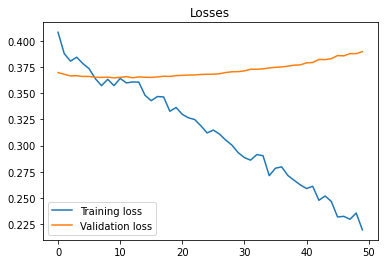

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

In [ ]:
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

In [ ]:
len(y_preds_np)
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_preds_np.round()))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       263
         1.0       0.00      0.00      0.00        37

    accuracy                           0.88       300
   macro avg       0.44      0.50      0.47       300
weighted avg       0.77      0.88      0.82       300



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_test_np = df_test[target_columns].values

In [ ]:
accuracy = accuracy_score(y_test, y_preds_np.round())
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_preds_np.round(), average='micro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_preds_np.round(), average='micro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_preds_np.round(),average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.865000
Precision: 0.865000
Recall: 0.865000
F1 score: 0.865000


In [ ]:
print(y_test_np)

[[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]

In [ ]:
auc_scores = roc_auc_score(y_test_np, y_preds_np, average=None)
df_accuracy = pd.DataFrame({"label": target_columns, "auc": auc_scores})
df_accuracy.sort_values('auc')[::-1]

,label,auc
0,label,0.480197


In [ ]:
positive_labels = df_train[target_columns].sum().sum()
positive_labels

117

In [ ]:
all_labels = df_train[target_columns].count().sum()
all_labels

1000

In [ ]:
positive_labels/all_labels

0.117

In [ ]:
df_test_targets = df_test[target_columns]
df_pred_targets = pd.DataFrame(y_preds_np.round(), columns=target_columns, dtype=int)
df_sanity = df_test_targets.join(df_pred_targets, how='inner', rsuffix='_pred')

In [ ]:
df_sanity

,label,label_pred
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
195,0,0
196,0,0
197,0,0
198,0,0


In [ ]:
df_test_targets.sum()

label    27
dtype: int64

In [ ]:
df_pred_targets.sum()

label    0
dtype: int64

In [ ]:
df_sanity[df_sanity.toxic > 0]['toxic', 'toxic_pred']

AttributeError: ignored